# VGG-18: Training from scratch

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras import regularizers
from tensorflow.keras import regularizers

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

from sklearn.metrics import accuracy_score, precision_score, recall_score


In [2]:
print(f"TensoFlow version: {tf.__version__}")

TensoFlow version: 2.4.1


In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
batch_size = 64
num_classes = 10
# num_epochs = 145
num_epochs = 60

In [5]:
weight_decay = 0.0005

In [6]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Load CIFAR-100 dataset-
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [8]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [9]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for TensorFlow _GradientTape_ training:

In [11]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [13]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [14]:
# Choose loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)

In [15]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

### Learning Rate Schedule:

Training size = 50,000 and batch size = 64. Number of training iterations/steps in one epoch = 781.25.

62,500 iterations has 80 epochs and 93,750 iterations has 120 epochs.


The learning rate schedule is as follows-

1. For the first 62,5001 training steps, use a learning rate of 0.01

1. For the next 31,250 training steps, use a learning rate of 0.001

1. For any remaing training steps, use a learning rate of 0.0001

In [ ]:
'''
boundaries = [62500, 93750]
values = [0.01, 0.001, 0.0001]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0012)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
'''

In [16]:
def vgg18_nn():
    '''
    Function to define the architecture of a convolutional neural network
    model following VGG-19 architecture for CIFAR-10 dataset.
    
    Vgg-19 architecture-
    64, 64, pool                 -- convolutional layers
    128, 128, pool               -- convolutional layers
    256, 256, 256, 256, max-pool -- convolutional layers
    512, 512, 512, 512, max-pool -- convolutional layers
    512, 512, 512, 512, avg-pool -- convolutional layers
    10                           -- fully connected layers
    
    Output: Returns designed and compiled convolutional neural network model
    '''

    # l = tf.keras.layers
    
    model = Sequential()
    
    model.add(
    Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same', kernel_regularizer = regularizers.l2(weight_decay),
            input_shape=(32, 32, 3)
        )
    )

    model.add(BatchNormalization())
    # model.add(Dropout(0.3))
    
    model.add(
    Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    # model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            kernel_regularizer = regularizers.l2(weight_decay)
        )
    )
    
    model.add(BatchNormalization())
    
    
    model.add(
        # AveragePooling2D(
        MaxPooling2D(
            pool_size=(2, 2), strides=(2, 2)
        )
    )
    
    # model.add(Dropout(0.5))
    
    model.add(Flatten())
    
  
    model.add(
    Dense(
            units = 512, activation='relu',
            kernel_initializer = tf.initializers.he_normal(),
            kernel_regularizer=regularizers.l2(weight_decay)
        )
    )
    
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    
    '''
    model.add(
    Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.he_normal()
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    '''
    
    model.add(
    Dense(
            units = num_classes, activation='softmax'
        )
    )

    
    return model


In [17]:
class VGGBlock(Layer):
    def __init__(self, num_filters = 32, use_four_block = False, weight_decay = 0.0005):
        super(VGGBlock, self).__init__()

        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = (3, 3),
            kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = False,
            kernel_regularizer = regularizers.l2(weight_decay)
            )
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(tf.nn.relu)
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = (3, 3),
            kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = False,
            kernel_regularizer = regularizers.l2(weight_decay)
            )
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(tf.nn.relu)
        
        if use_four_block:
            self.conv3 = Conv2D(
                filters = num_filters, kernel_size = (3, 3),
                kernel_initializer = tf.initializers.he_normal(),
                strides = (1, 1), padding = 'same',
                use_bias = False,
                kernel_regularizer = regularizers.l2(weight_decay)
            )
            self.bn3 = BatchNormalization()
            self.relu3 = Activation(tf.nn.relu)
            
            self.conv4 = Conv2D(
                filters = num_filters, kernel_size = (3, 3),
                kernel_initializer = tf.initializers.he_normal(),
                strides = (1, 1), padding = 'same',
                use_bias = False,
                kernel_regularizer = regularizers.l2(weight_decay)
            )
            self.bn4 = BatchNormalization()
            self.relu4 = Activation(tf.nn.relu)
        else:
            self.conv3 = None
            
        
        self.pool = MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
            )
        
        # self.pool = tf.keras.layers.GlobalAveragePooling2D()


    def call(self, inputs):
        x = self.relu1(self.bn1(self.conv1(inputs)))
        x = self.relu2(self.bn2(self.conv2(x)))
        
        # if use_four_block:
        if self.conv3:
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.relu4(self.bn4(self.conv4(x)))
        
        return self.pool(x)



In [21]:
class VGG19(Model):
    def __init__(self):
        super(VGG19, self).__init__()
        
        self.block1 = VGGBlock(num_filters = 64)
        self.block2 = VGGBlock(num_filters = 128)
        self.block3 = VGGBlock(num_filters = 256, use_four_block = True)
        self.block4 = VGGBlock(num_filters = 512, use_four_block = True)
        self.block5 = VGGBlock(num_filters = 512, use_four_block = True)
        
        weight_decay = 0.0005
        
        self.flatten = Flatten()
        self.dense1 =  Dense(
            units = 512, kernel_initializer = tf.initializers.he_normal(),
            kernel_regularizer = regularizers.l2(weight_decay)
            )
        # self.bn_dense = BatchNormalization()
        self.relu_dense = Activation(tf.nn.relu)
        # self.dropout_dense = Dropout(0.5)
        
        '''
        self.dense2 = Dense(
            units = 256, kernel_initializer = tf.initializers.he_normal()
            )
        self.relu2 = Activation(tf.nn.relu)
        # self.dropout2 = Dropout(0.4)
        '''

        self.op = Dense(
            units = num_classes, activation = 'softmax'
            )
    
    
    def call(self, inputs):
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.flatten(x)
        # x = self.dropout1(self.relu1(self.dense1(x)))
        x = self.relu_dense(self.dense1(x))
        # x = self.dropout2(self.relu2(self.dense2(x)))
        # x = self.relu2(self.dense2(x))
        return self.op(x)
    
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))



In [22]:
# Initialize a CNN model-
# orig_model = vgg18_nn()

orig_model = VGG19()
orig_model.build(input_shape = (None, 32, 32, 3))

In [78]:
# Load random weights of defined CNN-
# orig_model.load_weights("VGG18_Random_Weights_henormal_weight_decay_weights.h5")

In [23]:
# Save current weights-
orig_model.save_weights("VGG18_batchnorm_random_weights.h5", overwrite = True)

In [19]:
# lr_decay = 1e-6

In [27]:
# Get CNN model summary-
orig_model.model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg_block_2 (VGGBlock)       (None, 16, 16, 64)        39104     
_________________________________________________________________
vgg_block_3 (VGGBlock)       (None, 8, 8, 128)         222208    
_________________________________________________________________
vgg_block_4 (VGGBlock)       (None, 4, 4, 256)         2068480   
_________________________________________________________________
vgg_block_5 (VGGBlock)       (None, 2, 2, 512)         8265728   
_________________________________________________________________
vgg_block_6 (VGGBlock)       (None, 1, 1, 512)         9445376   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0   

### Image Augmentation using _ImageDataGenerator_:

Refer-
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#fit

In [28]:
# Example of using 'tf.keras.preprocessing.image import ImageDataGenerator class's - flow(x, y)':
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range = 15,
    width_shift_range = 0.1, # 0.2
    height_shift_range = 0.1, # 0.2
    horizontal_flip = True
)


# flow():
# Takes data & label arrays, generates batches of augmented data.

# datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
'''
for x, y in datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True):
	print(x.shape, y.shape)
'''

'\nfor x, y in datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True):\n\tprint(x.shape, y.shape)\n'

In [29]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [30]:
import tensorflow.keras.backend as K


# METHOD-1: This also counts biases
trainable_wts = np.sum([K.count_params(w) for w in orig_model.trainable_weights])
non_trainable_wts = np.sum([K.count_params(w) for w in orig_model.non_trainable_weights])

print("\nNumber of training weights = {0} and non-trainabel weights = {1}\n".format(
    trainable_wts, non_trainable_wts
))
print("Total number of parameters = {0}\n".format(trainable_wts + non_trainable_wts))



Number of training weights = 20297674 and non-trainabel weights = 11008

Total number of parameters = 20308682



In [31]:
tot_trainable_params = 0

for layer in orig_model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print("layer.shape = {0} has {1} trainable weights".format(layer.shape, loc_params))
    tot_trainable_params += loc_params
    
print("\nVGG-18 has a total of {0} trainable parameters\n".format(tot_trainable_params))

layer.shape = (3, 3, 3, 64) has 1728 trainable weights
layer.shape = (64,) has 64 trainable weights
layer.shape = (64,) has 0 trainable weights
layer.shape = (3, 3, 64, 64) has 36864 trainable weights
layer.shape = (64,) has 64 trainable weights
layer.shape = (64,) has 0 trainable weights
layer.shape = (3, 3, 64, 128) has 73728 trainable weights
layer.shape = (128,) has 128 trainable weights
layer.shape = (128,) has 0 trainable weights
layer.shape = (3, 3, 128, 128) has 147456 trainable weights
layer.shape = (128,) has 128 trainable weights
layer.shape = (128,) has 0 trainable weights
layer.shape = (3, 3, 128, 256) has 294912 trainable weights
layer.shape = (256,) has 256 trainable weights
layer.shape = (256,) has 0 trainable weights
layer.shape = (3, 3, 256, 256) has 589824 trainable weights
layer.shape = (256,) has 256 trainable weights
layer.shape = (256,) has 0 trainable weights
layer.shape = (3, 3, 256, 256) has 589824 trainable weights
layer.shape = (256,) has 256 trainable weigh

In [32]:
print("\nAccording to tf.keras.backend: Number of training weights = {0}, non-trainabel weights = {1} and total number of parameters = {2}\n".format(
    trainable_wts, non_trainable_wts, (trainable_wts + non_trainable_wts)
))

print("According to tf.math.count_nonzero() method, total number of trainable weights = {0}\n".format(tot_trainable_params))


According to tf.keras.backend: Number of training weights = 20297674, non-trainabel weights = 11008 and total number of parameters = 20308682

According to tf.math.count_nonzero() method, total number of trainable weights = 20291648



In [34]:
# Create mask for original, unpruned model-
# mask_model = vgg18_nn()
mask_model = VGG19()
mask_model.build(input_shape = (None, 32, 32, 3))


# Assign all masks to one-
for wts in mask_model.trainable_weights:
    wts.assign(
        tf.ones_like(input = wts, dtype = tf.float32
                    )
    )

'''
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-
for wts in mask_model.trainable_weights:
    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
'''

'\n# For each layer, for each weight which is 0, leave it, as is.\n# And for weights which survive the pruning,reinitialize it to ONE (1)-\nfor wts in mask_model.trainable_weights:\n    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))\n'

In [35]:
# Sanity check-
mask_params = 0

for layer in mask_model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    mask_params += loc_params
    
print("\nnumber of non-zero masks = {0}\n".format(mask_params))
# VGG-19 has a total of 20292095 trainable parameters


number of non-zero masks = 20297674



In [36]:
mask_params == tot_trainable_params

False

In [37]:
def count_params(model):
    model_sum_params = 0

    for layer in model.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    return model_sum_params
    

In [38]:
# Sanity check-
print(f"VGG-18 has {count_params(orig_model)} trainable parameters")

VGG-18 has 20291648 trainable parameters


In [39]:
# Compile defined CNN-
orig_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9),
    # optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn, momentum = 0.9),
    metrics=['accuracy']
)

### Learning rate warmup:

Using a large learning rate may result in numerical instability especially at the very beginning of training where parameters are randomly initialized. The warmup strategy increases the learning rate from 0 to the initial learning rate linearly during the initial __N__ epochs or __m__ batches.

Even though Keras already came with the _LearningRateScheduler_ capable of updating the learning rate for each training epoch, in order to achieve finer updates for each batch, the following code is how you can implement a custom Keras callback to do that.

In [41]:
from typing import Callable, List, Optional, Union

In [42]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Applies a warmup schedule on a given learning rate decay schedule.

    Args:
        initial_learning_rate (:obj:`float`):
            The initial learning rate for the schedule after the warmup (so this will be the learning rate at the end
            of the warmup).
            
        decay_schedule_fn (:obj:`Callable`):
            The schedule function to apply after the warmup for the rest of training.
        
        warmup_steps (:obj:`int`):
            The number of steps for the warmup part of training.
        
        power (:obj:`float`, `optional`, defaults to 1):
            The power to use for the polynomial warmup (defaults is a linear warmup).
        
        name (:obj:`str`, `optional`):
            Optional name prefix for the returned tensors during the schedule.
    """

    def __init__(
        self,
        initial_learning_rate: float,
        decay_schedule_fn: Callable,
        warmup_steps: int,
        power: float = 1.0,
        name: str = None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_schedule_fn": self.decay_schedule_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }
    

### Step Decay: Learning Rate Schedule

For CIFAR-10 dataset, the training dataset has 50K images and batch size = 64. Therefore, number of training steps in one epoch = 781.25 = 781. So, 10 epochs has 7813 training steps/iterations.

__After 10 epochs or 7813 training steps,__ the learning rate schedule is as follows-

- For the next 21094 training steps (or, 27 epochs), use a learning rate of 0.1

- For the next 13282 training steps (or, 17 epochs), use a learning rate of 0.01

- For any remaing training steps, use a learning rate of 0.001


In [43]:
boundaries = [21093, 34376]
values = [0.1, 0.01, 0.001]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

In [44]:
warmup_shcedule = WarmUp(initial_learning_rate = 0.1, decay_schedule_fn = learning_rate_fn, warmup_steps = 7813)

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate = warmup_shcedule, momentum = 0.9, decay = 0.0, nesterov = False)

### Train model using _tf.GradientTape_:

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [46]:
best_val_loss = 100
# loc_patience = 0

In [47]:
# Define 'train_one_step()' and 'test_step()' functions here-
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None
    
    
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None



In [48]:
# Python3 dict to contain model training metrics-
history_lr = {}

In [49]:
num_epochs

60

In [50]:
# Train model using 'GradientTape'-
    
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 100
# loc_patience = 0
    
for epoch in range(num_epochs):
    '''
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    # variable to keep track of current training step-
    curr_step = 0
    
    # Train using data augmentation (ImageDataGenerator())-
    for x, y in datagen.flow(X_train, y_train, batch_size = batch_size, shuffle = True):
    # for x, y in zip(augmented_train_batches, y_train):
        train_one_step(orig_model, mask_model, optimizer, x, y)
        # print("current step = ", curr_step)
        curr_step += 1
        
        # break out of infinite loop to end current training epoch-
        if curr_step >= X_train.shape[0] // batch_size:
            # print("\nTerminating training (datagen.flow())")
            break

    # Testing dataset-
    for x_t, y_t in test_dataset:
    # for x_t, y_t in zip(validation_batches, y_test):
        test_step(orig_model, optimizer, x_t, y_t)
    
    '''
    for x, y in train_dataset:
        train_one_step(winning_ticket_model, mask_model, optimizer, x, y)

    for x_t, y_t in test_dataset:
        test_step(winning_ticket_model, optimizer, x_t, y_t)

    '''

    '''
    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
    print(template.format(
        epoch + 1, train_loss.result(),
        train_accuracy.result() * 100, test_loss.result(),
        test_accuracy.result()  *100)
         )
    '''
       
    template = '\nEpoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}, LR: {5:.6f}, Current step value: {6}'

    print(template.format(
        epoch + 1, train_loss.result(), train_accuracy.result()*100,
        test_loss.result(), test_accuracy.result()*100,
        # optimizer.learning_rate.numpy()
        optimizer._decayed_lr('float32').numpy(),
        optimizer.iterations.numpy()
    )
         )
    
    history_lr[epoch + 1] = {'loss': train_loss.result(), 'acc': train_accuracy.result() * 100, 'val_loss': test_loss.result(),
                                      'val_acc': test_accuracy.result() * 100, 'lr': optimizer._decayed_lr('float32').numpy(),
                                      'step_val': optimizer.iterations.numpy()
                                     }
    
    
    # Count number of non-zero parameters in each layer and in total-
    print(f"VGG-18: total # of trainable parameters = {count_params(orig_model)}")
    
    # Insert manual implementation of code for early stopping here.
    
    
    # Save best weights achieved until now-
    if (test_loss.result() < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        print(f"Saving model with lowest val_loss = {test_loss.result():.4f}\n")
        
        # Save trained model with validation accuracy-
        orig_model.save_weights("VGG18_best_trained_loss.h5", overwrite = True)
   


Epoch 1, Loss: 1.9039, Accuracy: 28.7912, Test Loss: 1.5985, Test Accuracy: 43.349998, LR: 0.009996, Current step value: 781
VGG-18: total # of trainable parameters = 20297654
Saving model with lowest val_loss = 1.5985


Epoch 2, Loss: 1.5104, Accuracy: 44.8564, Test Loss: 1.3506, Test Accuracy: 51.590000, LR: 0.019992, Current step value: 1562
VGG-18: total # of trainable parameters = 20297667
Saving model with lowest val_loss = 1.3506


Epoch 3, Loss: 1.3259, Accuracy: 52.6208, Test Loss: 1.1812, Test Accuracy: 59.670002, LR: 0.029988, Current step value: 2343
VGG-18: total # of trainable parameters = 20297673
Saving model with lowest val_loss = 1.1812


Epoch 4, Loss: 1.2224, Accuracy: 57.3484, Test Loss: 1.0485, Test Accuracy: 64.610001, LR: 0.039985, Current step value: 3124
VGG-18: total # of trainable parameters = 20297674
Saving model with lowest val_loss = 1.0485


Epoch 5, Loss: 1.1588, Accuracy: 60.1473, Test Loss: 1.1105, Test Accuracy: 63.300003, LR: 0.049981, Current ste

In [51]:
print("\nFinished training VGG-18 CNN\n")


Finished training VGG-18 CNN



In [52]:
import pickle

with open("VGG18_batchnorm_subclass_history_lr.pkl", "wb") as file:
    pickle.dump(history_lr, file)


In [53]:
# Initialize & load best weights model-
best_model = VGG19()
best_model.build(input_shape = (None, 32, 32, 3))
# best_model = vgg18_nn()

best_model.load_weights("VGG18_best_trained_loss.h5")

In [55]:
# Compile model-
best_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(learning_rate = warmup_shcedule, momentum = 0.9, decay = 0.0, nesterov = False),
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
    metrics=['accuracy']
)

In [56]:
# Evaluate trained model's validation loss and validation accuracy on validation dataset-
loss, acc = best_model.evaluate(X_test, y_test, verbose = 0)

In [57]:
print("\nTrained VGG-18 CNN model metrics on validation dataset:")
print("validation loss = {0:.4f} and validation accuracy = {1:.4f}%\n".format(loss, acc * 100))


Trained VGG-18 CNN model metrics on validation dataset:
validation loss = 27.2752 and validation accuracy = 89.6300%



### Visualize learning rate during training:

In [58]:
plot_lr = {}

In [59]:
for epoch in history_lr.keys():
    plot_lr[epoch] = history_lr[epoch]['lr']

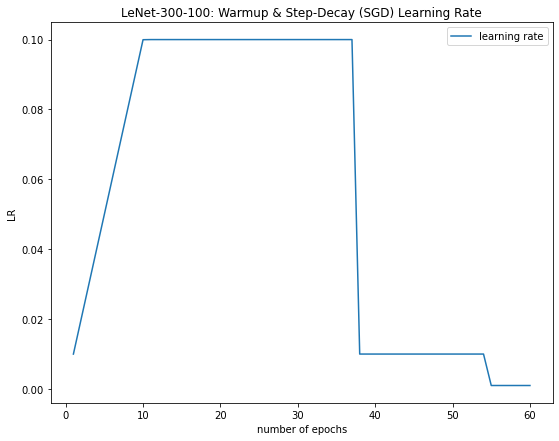

In [60]:
# Visualize learning rate during training-
plt.figure(figsize = (9, 7))

plt.plot(list(plot_lr.keys()), list(plot_lr.values()), label = 'learning rate')

# plt.title("LeNet-300-100: LR & step values")
plt.title("LeNet-300-100: Warmup & Step-Decay (SGD) Learning Rate")
plt.xlabel("number of epochs")
plt.ylabel("LR")
plt.legend(loc = 'best')
plt.show()